# Exploration04 - 작사가 인공지능 만들기

텍스트를 분석하여 스스로 작문하는 인공지능을 만들어보자.

---

### 루브릭 평가 기준

1. 모델의 정상 동작 - 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되나
2. 데이터 전처리와 데이터셋 구성 과정의 진행 - 특수문자 제거, 토크나이저 생성, 패딩 처리 등의 과정이 빠짐 없이 진행되었나
3. 모델의 안정적 학습 - 모델의 validation loss 가 2.2 이하로 낮아졌나

---

### 목차

0) 필요 모듈 import


1) 데이터
  - 데이터 로드 및 확인
  - 데이터 정제
  - 토큰화 및 텐서 변환
  - 데이터 분할
   
    
2) 모델
  - 모델 설계
  - 학습


3) 결과 확인
    

4) 데이터 중복 제거


5) 회고


## 0. 필요 모듈 import

In [1]:
import os
import glob
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 1. 데이터

텍스트 데이터를 분석하고 전처리한다.

### - 데이터 로드 및 확인

데이터를 로드하고 확인해보자.

In [2]:
file_path = os.getcwd() + '/data/lyrics/*'

txt_list = glob.glob(file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### - 데이터 정제

정규표현식을 이용하여 불필요한 공백과 특수문자 등을 지우고 원하는 길이의 데이터만 남긴다.

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [4]:
corpus = []

for sentence in raw_corpus:
    # 빈 문장 삭제
    if len(sentence) == 0:
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # <strat>와 <end> 토큰을 포함해 17개가 넘는 문장 삭제
    if len(preprocessed_sentence.split(' ')) > 17:
        continue
        
    corpus.append(preprocessed_sentence)


corpus[:3]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>']

지나치게 긴 문장들은 과도한 padding을 만든다.  
이를 방지하기 위해 문장의 토큰의 개수가 15개를 넘어가는 문장을 제거하고자 한다.  
\<start\>와 \<end\> 토큰을 포함해 17개가 넘는 문장을 삭제하였다.   

 
정제를 거친 문장을 보면 불필요한 특수문자를 삭제하고 문장 부호와 단어 사이에 공백이 삽입되었음을 확인할 수 있다.

### - 토큰화 및 텐서 변환

문장들을 쪼개어 텐서로 변환시킨다.

In [5]:
def tokenize(corpus):
    # 15000 단어 사용
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )
    
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2930 ...    0    0    0]
 [   2   32    7 ...    0    0    0]
 ...
 [   2  261  192 ...    0    0    0]
 [   2  132    4 ...   10 1070    3]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fa2a9f99d30>


사전의 전체 단어는 15000개로 정하였다. 이에 속하지 않는 단어는 \<unk\>으로 대체한다.  
corpus를 토큰화하고 텐서로 변환한다.  
시퀀스의 길이를 일정하게 만들기 위해 padding을 넣어주는데, 'post' 옵션을 통해 문자열의 뒤에 패딩을 넣어준다.  


tokenize( )함수를 통해 변환된 결과를 확인해보자.

In [6]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [7]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])
src_input.shape

[   2   50    4   95  308   62   55    9  972 6004    3    0    0    0
    0    0]
[  50    4   95  308   62   55    9  972 6004    3    0    0    0    0
    0    0]


(163714, 16)

src_input : 소스 문장 - tensor에서 마지막 토큰을 잘라내어 생성  
tgt_input : 타켓 문장 - tensor에서 첫번째 토큰 \<start\>를 잘라내어 생성

### - 데이터 분할

train data와 validation data를 나누어 학습에 사용한다.

In [8]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=10)

print("shape of source train set: ", enc_train.shape)
print("shape of target train set: ", dec_train.shape)

shape of source train set:  (130971, 16)
shape of target train set:  (130971, 16)


In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 15000개에 0:<pad>를 포함하여 15001개
VOCAB_SIZE = tokenizer.num_words + 1   

# training dataset
dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

# validation dataset
dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

## 2. 모델

### - 모델 설계

노드 학습 내용과 동일한 모델을 만들어 사용해보자.

In [10]:
# model build

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [11]:
# 하이퍼파라미터
embedding_size = 512
hidden_size = 2048

model = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

embedding_size : 워드 벡터의 차원수   
hidden_size : hidden state의 차원수

노드 학습에 사용했던 데이터에 비해 양도 많고 단어도 훨씬 다양할 것이라는 생각에 하이퍼파라미터를 각각 2배로 설정하였다.

In [12]:
optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

hist_1 = model.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
511/511 [==============================] - 351s 646ms/step - loss: 3.0863 - val_loss: 2.6918
Epoch 2/10
511/511 [==============================] - 332s 650ms/step - loss: 2.5555 - val_loss: 2.4741
Epoch 3/10
511/511 [==============================] - 333s 652ms/step - loss: 2.2906 - val_loss: 2.3229
Epoch 4/10
511/511 [==============================] - 333s 651ms/step - loss: 2.0428 - val_loss: 2.2074
Epoch 5/10
511/511 [==============================] - 333s 652ms/step - loss: 1.8093 - val_loss: 2.1205
Epoch 6/10
511/511 [==============================] - 333s 651ms/step - loss: 1.5899 - val_loss: 2.0554
Epoch 7/10
511/511 [==============================] - 333s 652ms/step - loss: 1.3899 - val_loss: 2.0108
Epoch 8/10
511/511 [==============================] - 333s 653ms/step - loss: 1.2179 - val_loss: 1.9891
Epoch 9/10
511/511 [==============================] - 346s 677ms/step - loss: 1.0780 - val_loss: 1.9862
Epoch 10/10
511/511 [==============================] - 332s 650m

### * val_loss가 2.2 아래로 떨어졌으므로 루브릭 기준 달성!!   ( ๑˃̶ ꇴ ˂̶)♪⁺

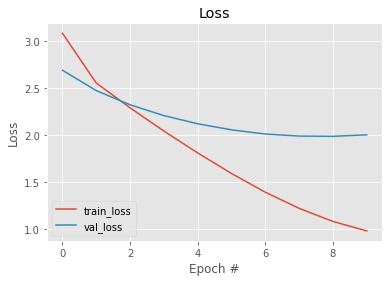

In [13]:
N = 10    # 각 epoch 마다의 결과를 보기 위해

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist_1.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist_1.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig('loss_1st.png')

그래프로 확인 결과 val_loss가 더 줄어들지 않고 수렴했음을 알 수 있다.

## 3. 결과 확인

학습된 모델이 작사를 잘 하는지 확인해보자.

In [14]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

- 입력 받은 init_sentence를 텐서로 변환
- 반복문을 돌며 단어를 예측
- 예측된 단어를 문장에 추가
- 모델이 \<end\>를 예측하거나 max_len에 도달하면 종료

In [15]:
generate_text(model, tokenizer, init_sentence="<start> i")

'<start> i m not living if you re not by my side <end> '

In [16]:
generate_text(model, tokenizer, init_sentence="<start> i know")

'<start> i know you re wondering when <end> '

In [17]:
generate_text(model, tokenizer, init_sentence="<start> you")

'<start> you re not easy to love , no <end> '

In [18]:
generate_text(model, tokenizer, init_sentence="<start> he is")

'<start> he is a loser , he s a bum , bum , bum <end> '

val_loss는 루브릭 기준을 달성하여 수치상으로는 꽤나 괜찮은 모델처럼 보인다.  
하지만 누가봐도 기존의 노래가사와 완전히 동일한 문장을 만들어 내는 것으로 보아 표절 논란이 심각할 듯 하다.  
수치상의 기준을 충족시키기 위해 하이퍼파라미터를 높인 결과 과적합이 된 것 같다.  
중복 데이터를 제거하지 않았기 때문에 train data와 validation data의 유사성이 높아 발생한 문제인 것으로 판단된다. 

## 4. 데이터 중복 제거

kanye-west.txt 와 Kanye_West.txt, lil-wayne.txt와 Lil_Wayne.txt 처럼 제목과 내용이 거의 유사한 데이터나 노래의 후렴구 등 중복되는 데이터가 많이 존재한다.  
이를 제거하고 학습을 진행한다면 어떤 결과가 나올까?  

In [19]:
raw_corpus_set = set(raw_corpus)

print(len(raw_corpus_set))

118168


In [20]:
corpus = []

for sentence in raw_corpus_set:
    if len(sentence) == 0:
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    
    if len(preprocessed_sentence.split(' ')) > 17:
        continue
        
    corpus.append(preprocessed_sentence)

In [21]:
tensor, tokenizer = tokenize(corpus)

[[  2  28  76 ...   0   0   0]
 [  2   9 595 ...  21 192   3]
 [  2   8  44 ...   0   0   0]
 ...
 [  2 315  11 ...   0   0   0]
 [  2  43   1 ...   0   0   0]
 [  2   5  40 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7fa21deebaf0>


In [22]:
src_input = tensor[:, :-1]
tgt_input = tensor[:, 1:]

print(src_input[0])
print(tgt_input[0])
src_input.shape

[   2   28   76   19    6 1448    4    6 1335   50  300    4    3    0
    0    0]
[  28   76   19    6 1448    4    6 1335   50  300    4    3    0    0
    0    0]


(108097, 16)

In [23]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=5)

print("shape of source train set: ", enc_train.shape)
print("shape of target train set: ", dec_train.shape)

shape of source train set:  (86477, 16)
shape of target train set:  (86477, 16)


In [24]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

# training dataset
dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

# validation dataset
dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

In [25]:
embedding_size = 512
hidden_size = 2048

model_2 = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

In [26]:
model_2.compile(loss=loss, optimizer=optimizer)

hist_2 = model_2.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
337/337 [==============================] - 232s 637ms/step - loss: 3.7575 - val_loss: 3.2452
Epoch 2/10
337/337 [==============================] - 215s 639ms/step - loss: 3.1305 - val_loss: 3.0667
Epoch 3/10
337/337 [==============================] - 215s 639ms/step - loss: 2.9718 - val_loss: 2.9739
Epoch 4/10
337/337 [==============================] - 216s 640ms/step - loss: 2.8837 - val_loss: 2.9282
Epoch 5/10
337/337 [==============================] - 216s 641ms/step - loss: 2.8264 - val_loss: 2.8992
Epoch 6/10
337/337 [==============================] - 216s 641ms/step - loss: 2.7805 - val_loss: 2.8806
Epoch 7/10
337/337 [==============================] - 216s 641ms/step - loss: 2.7384 - val_loss: 2.8604
Epoch 8/10
337/337 [==============================] - 216s 641ms/step - loss: 2.6998 - val_loss: 2.8444
Epoch 9/10
337/337 [==============================] - 216s 640ms/step - loss: 2.6643 - val_loss: 2.8324
Epoch 10/10
337/337 [==============================] - 216s 641m

### * val_loss는 루브릭 기준을 달성할 만큼 떨어지지 않았다.

중복 데이터를 제거했기 때문에 train data와 validation data 사이에 유사성이 적어 이러한 결과가 나왔을 것이라 추측해본다.

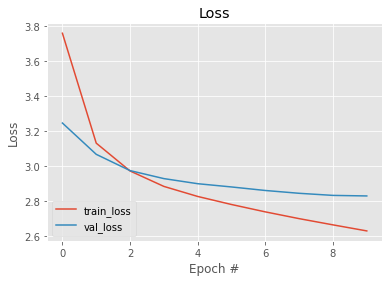

In [27]:
N = 10    # 각 epoch 마다의 결과를 보기 위해

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist_2.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist_2.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig('loss_2nd.png')

그래프 상 val_loss가 어느정도 수렴한 것으로 보여 epoch을 늘린다고 결과가 크게 개선되지는 않을 것 같다.  


두번째 모델의 작사 실력을 확인해보자.

In [28]:
generate_text(model_2, tokenizer, init_sentence="<start> i")

'<start> i m gonna be a way <end> '

In [29]:
generate_text(model_2, tokenizer, init_sentence="<start> i know")

'<start> i know i m gonna be <end> '

In [30]:
generate_text(model_2, tokenizer, init_sentence="<start> you")

'<start> you re gonna be the same <end> '

In [31]:
generate_text(model_2, tokenizer, init_sentence="<start> he is")

'<start> he is a little man <end> '

첫번째 모델보다는 표절 의혹이 줄어들 것 같다.  
검색 결과 유사한 가사가 존재하긴 하지만 첫번째 모델처럼 데이터로 사용된 가사와 완전하게 동일한 문장을 내놓지는 않는다.  
val_loss는 조금 높아 성능이 안좋은 것 처럼 보이지만 오히려 과적합이 되지 않은, 작사가라는 이름에 더 가까운 모델이 탄생한 것 같다.

## 회고

#### - 자연어처리의 어려움 

NLP 관련된 첫 노드라 그런지 많이 어려웠다. 결과 확인 후 어느 부분이 문제인지 눈에 보이지 않아 모델 개선을 위해 어느 부분을 수정해야 하는 것인지도 모르겠다.  
val_loss가 루브릭 기준을 충족시키지 못해도 문장을 생성해보면 나름 그럴싸한 문장을 내뱉었기 때문에 중간에 너무 그만두고 싶었다.  
분석하고자 하는 언어에 대한 지식도 필요하고 사람이 쓰는 말을 흉내내기 위해서는 많은 변수들을 고려해야 한다고 느꼈다.  

#### - overfitting

루브릭 기준 충족을 위해 val_loss를 낮추려고 embedding_size와 hidden_size를 키웠더니 첫번째 모델처럼 노래 가사를 그대로 출력하는 현상이 발생하였다. 2.2 이하라는 루브릭 기준을 맞추기는 했지만 창작을 하는 작사가라고는 할 수 없는 모델이다.  
중간 과정에서 val_loss값이 기준을 충족하지 않아 버려진 모델들이 만든 문장이 더 작사에 가까웠다고 할 수 있겠다.  
단지 수치만이 모델의 완성도를 나타내지는 않는다는 생각이 들었다.   

#### - 단어를 15000 개로 잡은 이유  
처음에 단어의 수를 12000개로 설정 후 토큰화를 하고 학습을 진행하였는데 작문된 문장에서 \<unk\>이 너무 많이 등장했다. 단어의 개수가 부족하여 이러한 결과가 나왔다는 생각에 토큰화할 단어의 개수를 더 늘려주었다.